# Cogs 118C Final Project

## Anand Mysorekar, Leo Fleury, & Ava Rubin

# Loading Data

In [19]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

In [20]:
control_path = r'Control_EEG_sub_027.npy'
Control = np.load(control_path) * 1e6

In [21]:
ad_path = r'AD_EEG_sub_001.npy'
AD = np.load(ad_path) * 1e6

In [22]:
fs = 500
num_samples = Control.shape[1]

time = np.linspace(0, num_samples / fs, num_samples)

channels = ['Fp1', 'Fp2', 'F3']
colors = ['r', 'g', 'b']

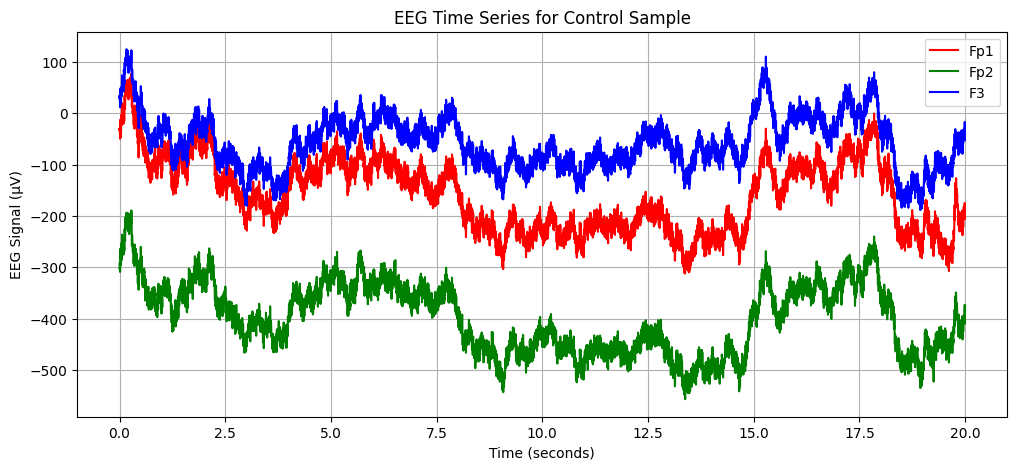

In [23]:
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(time, Control[i, :], label=channels[i], color=colors[i])

plt.xlabel("Time (seconds)")
plt.ylabel("EEG Signal (µV)")
plt.title("EEG Time Series for Control Sample")
plt.legend()
plt.grid(True)

plt.show()

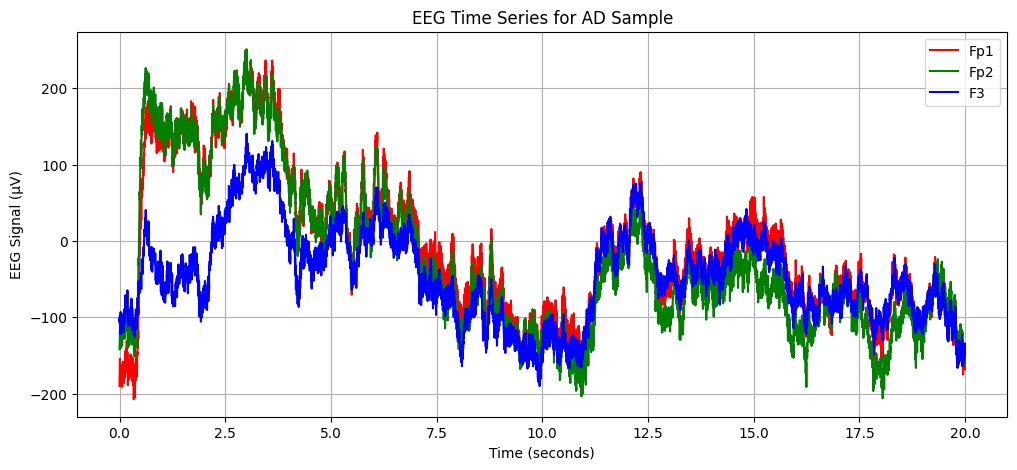

In [24]:
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(time, AD[i, :], label=channels[i], color=colors[i])

plt.xlabel("Time (seconds)")
plt.ylabel("EEG Signal (µV)")
plt.title("EEG Time Series for AD Sample")
plt.legend()
plt.grid(True)

plt.show()